In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Задача
# 1. Сгенерируйте набор данных для предсказания временных последовательностей. Выполните тренировку RNN
# 2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

# 3. решите задачу набора данных лекции 7.

In [ ]:
#1
def create_sequences(length, data_size):
    inputs = []
    outputs = []
    time = np.linspace(0, data_size, 1000)
    signal = np.sin(time)
    for i in range(len(signal)-length):
        input_seq = signal[i:(i+length)]
        output_val = signal[i+length]
        inputs.append(input_seq)
        outputs.append(output_val)
    return np.array(inputs), np.array(outputs), time, signal

In [ ]:
dataset_length = 50
sequence_len = 20

inputs, targets, time_vals, signal_data = create_sequences(sequence_len, dataset_length)

train_inputs = torch.tensor(inputs[:, :, None], dtype=torch.float32)
train_targets = torch.tensor(targets[:, None], dtype=torch.float32)

In [ ]:
print('Total number of sequences of', sequence_len, 'points')
train_inputs.size()

Total number of sequences of 20 points


torch.Size([980, 20, 1])

In [ ]:
print('Total number of points continuing the sequence')
train_targets.size()

Total number of points continuing the sequence


torch.Size([980, 1])

In [ ]:
#RNN
class BasicRNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size, layers):
        super(BasicRNN, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_dim, hidden_size, layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x, hidden_state):
        batch_size = x.size(0)
        rnn_out, hidden_state = self.rnn(x, hidden_state)
        output = self.fc(rnn_out[:, -1, :])
        return output, hidden_state

In [ ]:
#train
def train_model(model, total_steps, display_interval, x_data, y_data, time_vals, signal_data, seq_len):
    hidden_state = None

    for step in range(total_steps):
        prediction, hidden_state = model(x_data, hidden_state)
        hidden_state = hidden_state.data

        loss = criterion(prediction, y_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % display_interval == 0:
            print(f'Epoch [{step}/{total_steps}], Loss: {loss.item():.4f}')
            plt.plot(time_vals, signal_data, 'r-', label='Original')
            plt.plot(time_vals[seq_len:], prediction.data.numpy().flatten(), 'b--', label='Predicted')
            plt.legend()
            plt.show()

    return model

In [ ]:
input_dim = 1
output_dim = 1
hidden_size = 32
num_layers = 1

rnn_model = BasicRNN(input_dim, output_dim, hidden_size, num_layers)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.01)

print(rnn_model)

BasicRNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


Epoch [0/75], Loss: 0.5134


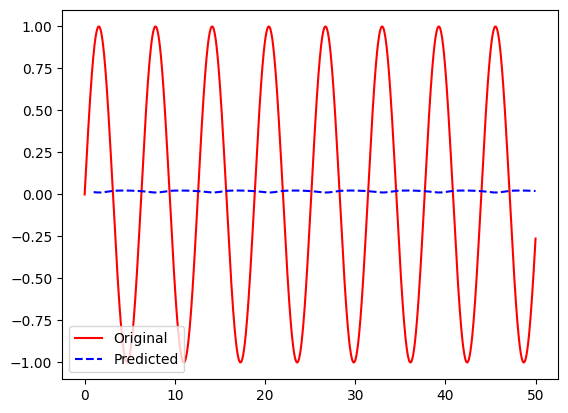

Epoch [5/75], Loss: 0.1679


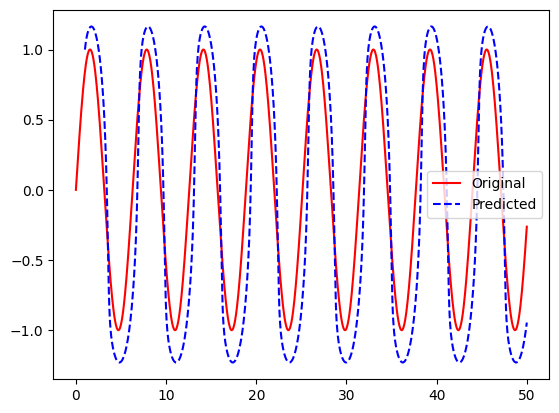

Epoch [10/75], Loss: 0.0531


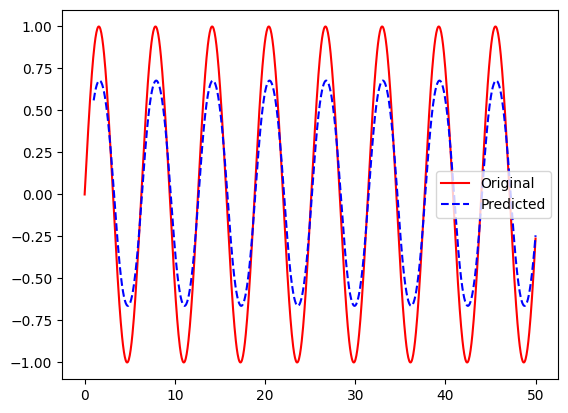

Epoch [15/75], Loss: 0.0140


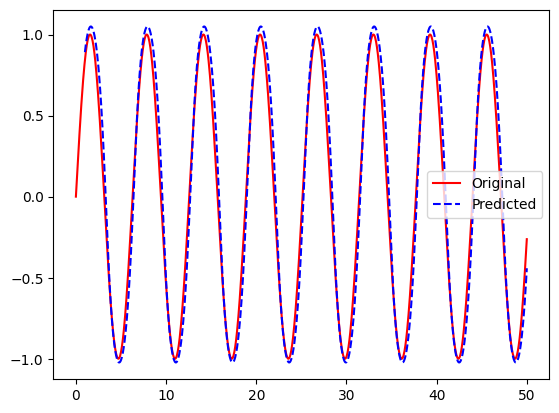

Epoch [20/75], Loss: 0.0064


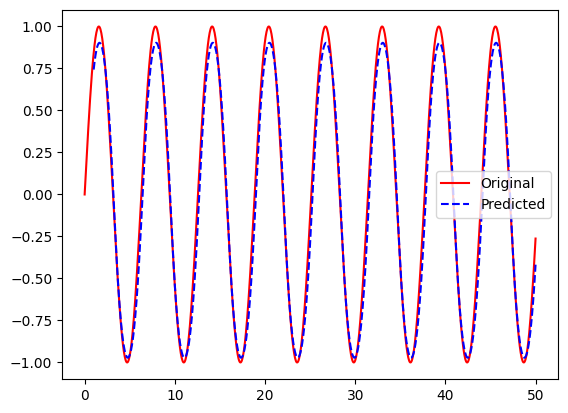

Epoch [25/75], Loss: 0.0110


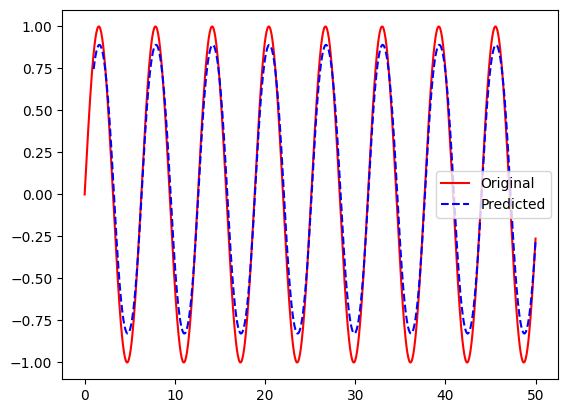

Epoch [30/75], Loss: 0.0071


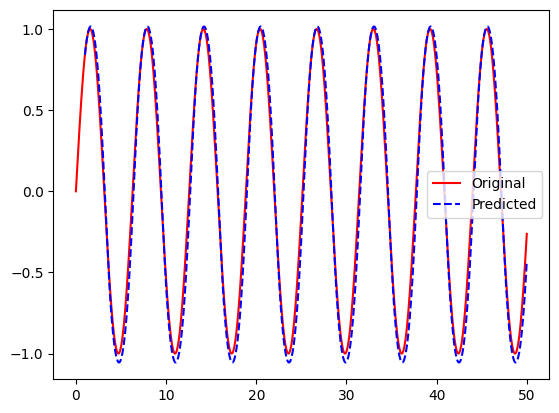

Epoch [35/75], Loss: 0.0028


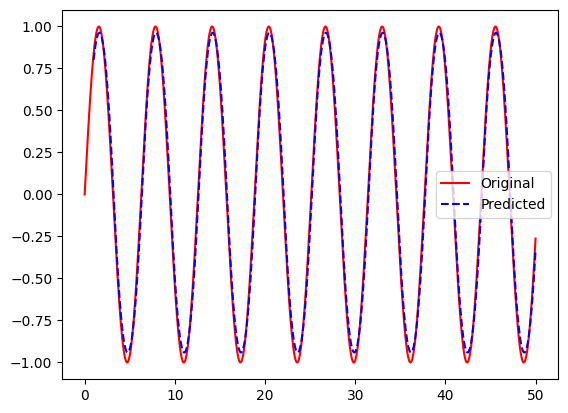

Epoch [40/75], Loss: 0.0031


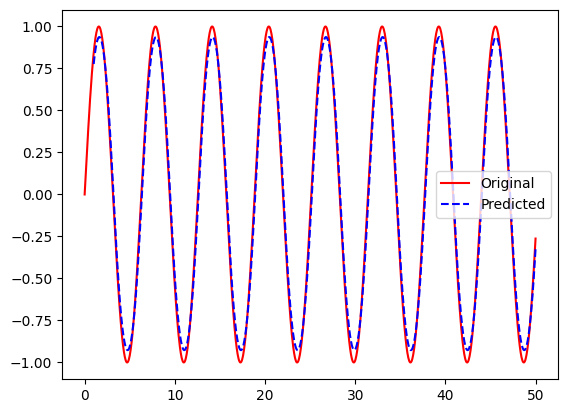

Epoch [45/75], Loss: 0.0029


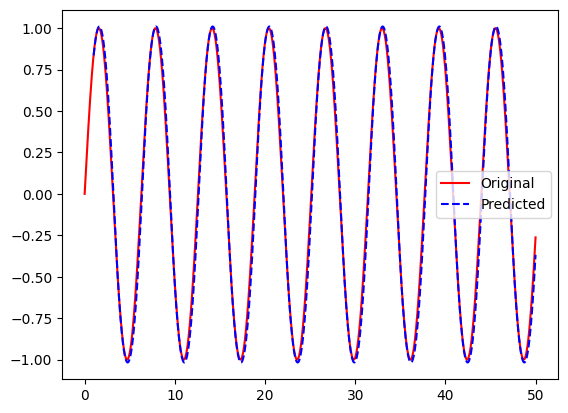

Epoch [50/75], Loss: 0.0019


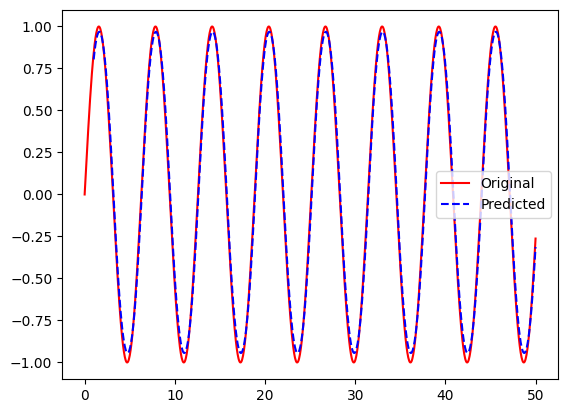

Epoch [55/75], Loss: 0.0014


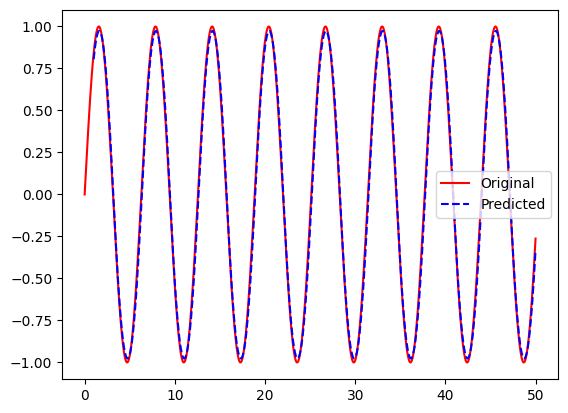

Epoch [60/75], Loss: 0.0013


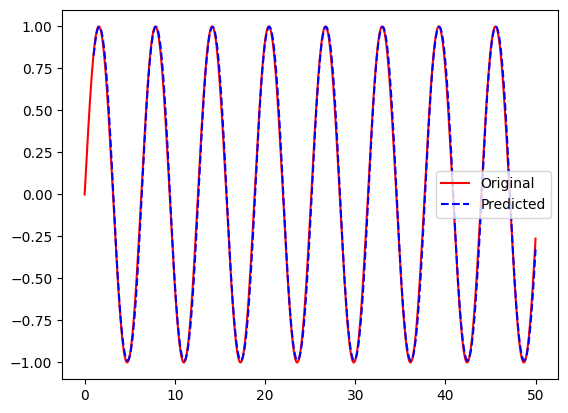

Epoch [65/75], Loss: 0.0011


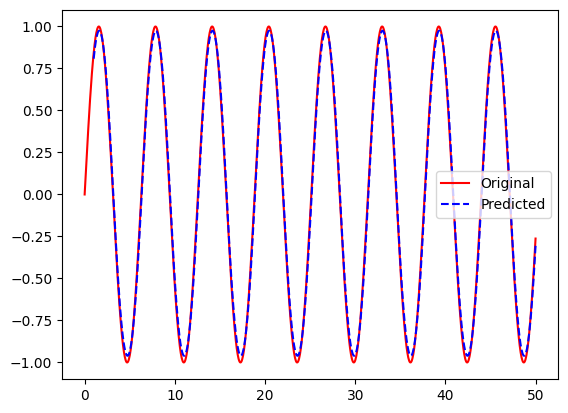

Epoch [70/75], Loss: 0.0009


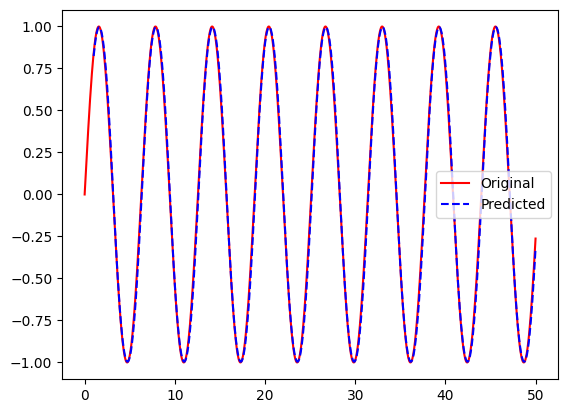

In [ ]:
num_epochs = 75
display_interval = 5

trained_rnn = train_model(rnn_model, num_epochs, display_interval, train_inputs, train_targets, time_vals, signal_data, sequence_len)

In [ ]:
#2
#lstm
class BasicLSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size, layers):
        super(BasicLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = layers
        self.lstm = nn.LSTM(input_dim, hidden_size, layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x, hidden_state, cell_state):
        if hidden_state is None or cell_state is None:
            hidden_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            cell_state = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        batch_size = x.size(0)
        lstm_out, (hn, cn) = self.lstm(x, (hidden_state, cell_state))
        output = self.fc(lstm_out[:, -1, :])
        return output, hn, cn

In [ ]:
input_dim = 1
output_dim = 1
hidden_size = 100
num_layers = 1

lstm_model = BasicLSTM(input_dim, output_dim, hidden_size, num_layers)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

print(lstm_model)

BasicLSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:
#train
def train_lstm_model(model, total_epochs, display_interval, x_data, y_data, time_vals, signal_data, seq_len):
    hidden_state, cell_state = None, None
    for step in range(total_epochs):
        model.train()
        optimizer.zero_grad()

        prediction, hidden_state, cell_state = model(x_data, hidden_state, cell_state)

        loss = criterion(prediction, y_data)

        loss.backward()
        optimizer.step()

        hidden_state = hidden_state.detach()
        cell_state = cell_state.detach()

        if step % display_interval == 0:
            print(f'Epoch [{step}/{total_epochs}], Loss: {loss.item():.4f}')
            plt.plot(time_vals, signal_data, 'r-', label='Original')
            plt.plot(time_vals[seq_len:], prediction.data.numpy().flatten(), 'b--', label='Predicted')
            plt.legend()
            plt.show()

    return model

Epoch [0/75], Loss: 0.5183


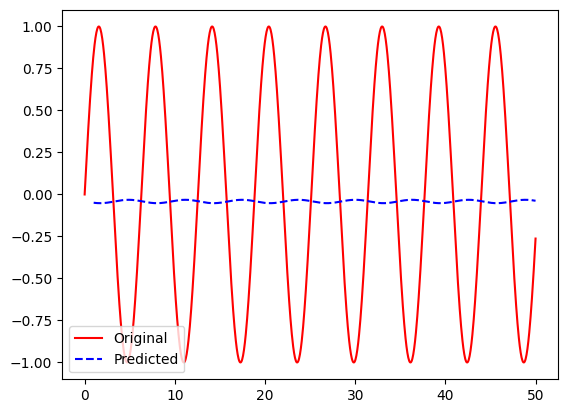

Epoch [5/75], Loss: 0.0926


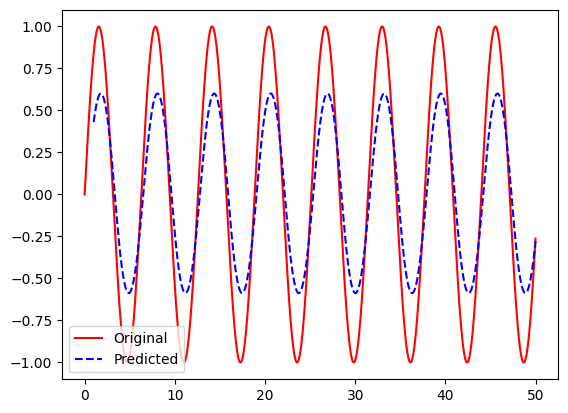

Epoch [10/75], Loss: 0.0336


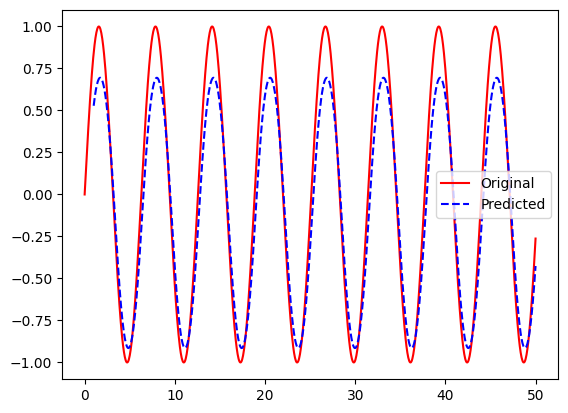

Epoch [15/75], Loss: 0.0203


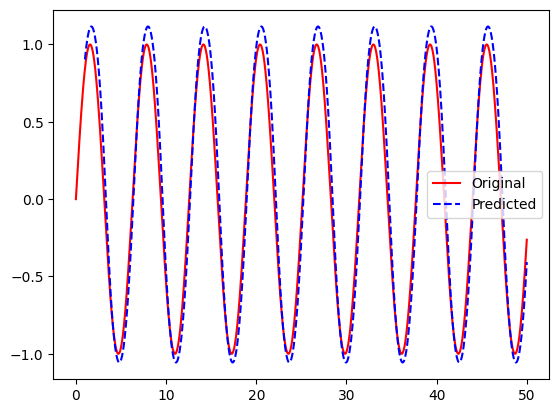

Epoch [20/75], Loss: 0.0106


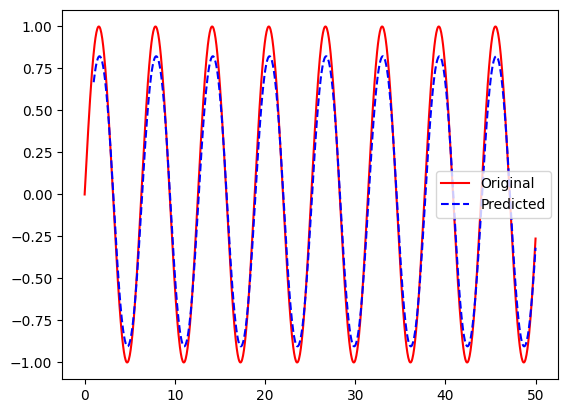

Epoch [25/75], Loss: 0.0046


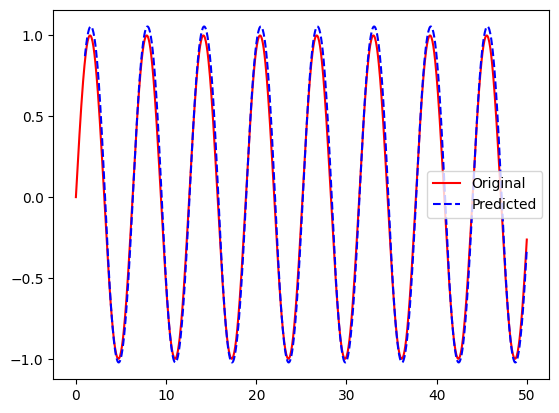

Epoch [30/75], Loss: 0.0017


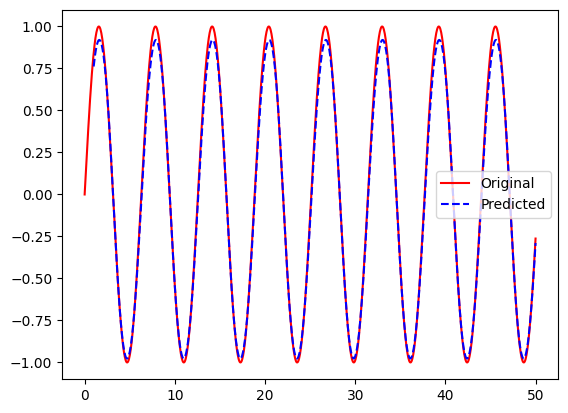

Epoch [35/75], Loss: 0.0006


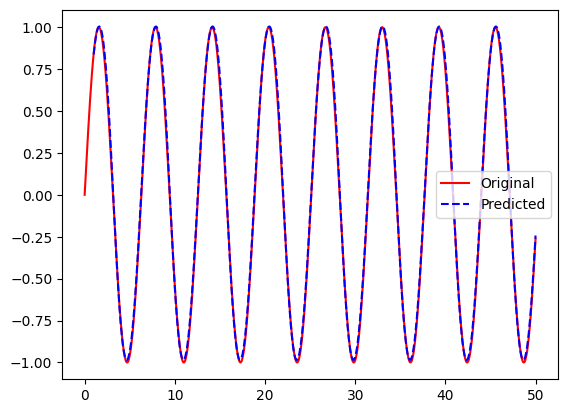

Epoch [40/75], Loss: 0.0005


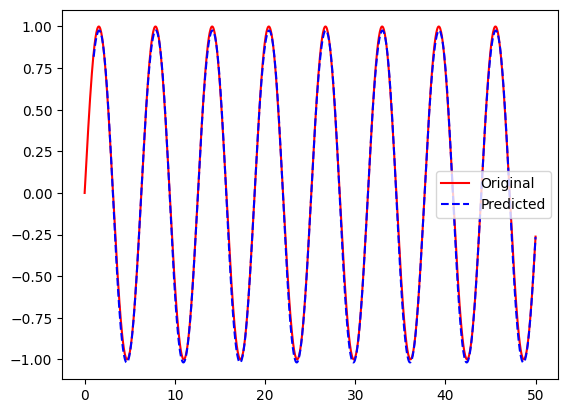

Epoch [45/75], Loss: 0.0003


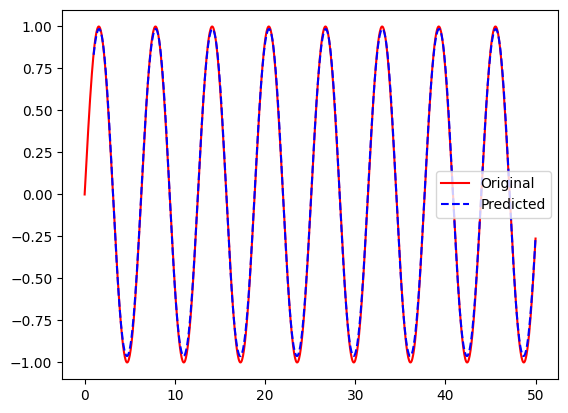

Epoch [50/75], Loss: 0.0002


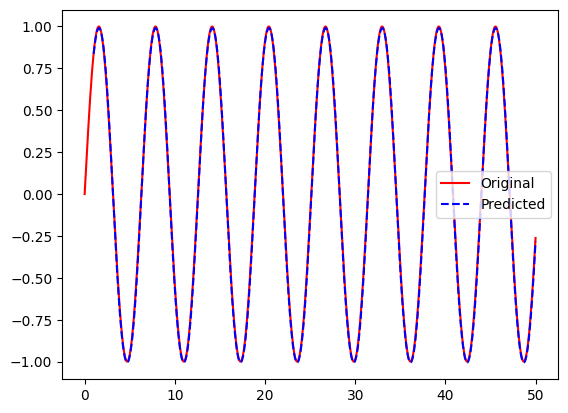

Epoch [55/75], Loss: 0.0001


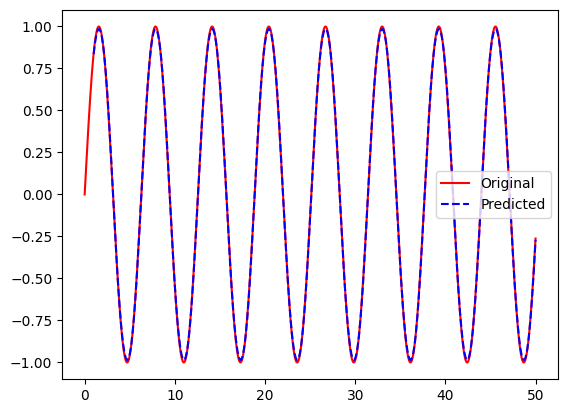

Epoch [60/75], Loss: 0.0001


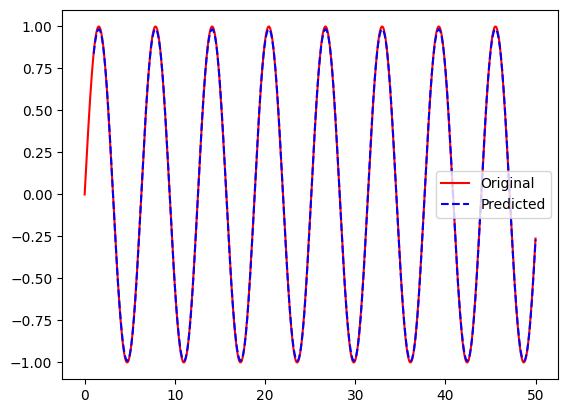

Epoch [65/75], Loss: 0.0001


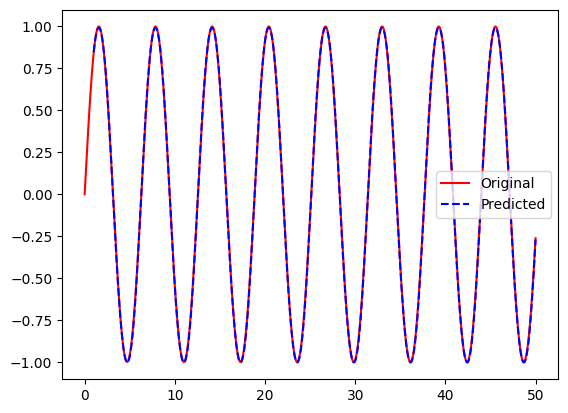

Epoch [70/75], Loss: 0.0001


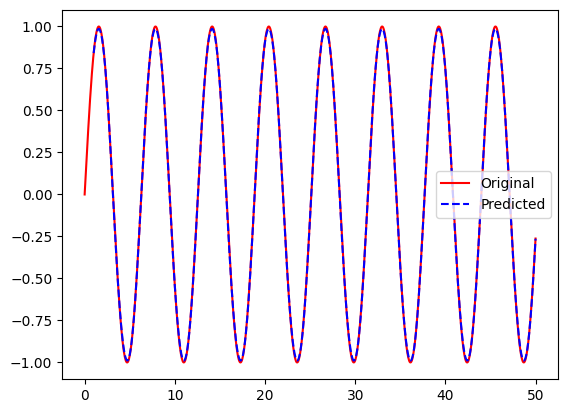

In [ ]:
dataset_length = 50
sequence_len = 20
total_epochs = 75
inputs, targets, time_vals, signal_data = create_sequences(sequence_len, dataset_length)
train_inputs = torch.tensor(inputs[:, :, None], dtype=torch.float32)
train_targets = torch.tensor(targets[:, None], dtype=torch.float32)

display_interval = 5

trained_lstm_model = train_lstm_model(lstm_model, total_epochs, display_interval, train_inputs, train_targets, time_vals, signal_data, sequence_len)

In [ ]:
#3